### Imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from pathlib import Path

import gvpy as gv
import sbemoored as sbe

%reload_ext autoreload
%autoreload 2
%autosave 300

%config InlineBackend.figure_format = 'retina'

Autosaving every 300 seconds


In [2]:
import jupyter_black
jupyter_black.load(lab=False)

In [3]:
gv.plot.helvetica()
mpl.rcParams["lines.linewidth"] = 1

In [4]:
pd.set_option("display.max_colwidth", None)

# BLT1 SBE56 post-deployment CTD cast

Process the thermistor time series from the CTD calibration cast on Oct 13, 2021, during the BLT2 cruise after the BLT1 mooring recoveries.
Thermistor data from the CTD calibration cast are contained in small files that are separate from the BLT1 data.

Update: Ran the processing on all SBE56.

## Processing parameters

In [2]:
mooring_dir = Path("/Users/gunnar/Projects/blt/data/BLT/Moorings/BLT1/")

sbe_dir = mooring_dir.joinpath("MAVS/SBE56 CTD PostCal")
data_raw = sbe_dir.joinpath("raw")
data_out = sbe_dir.joinpath("proc")
figure_out = sbe_dir.joinpath("fig")

# Create directories if needed
for d in [data_out, figure_out]:
    d.mkdir(exist_ok=True)

## Get file name

In [3]:
def get_file_name(sn, data_raw, extension='csv'):
    files = list(data_raw.glob(f'SBE056{sn:05}*.{extension}'))
    if len(files) == 1:
        return files[0]
    elif len(files) == 0:
        return None
    else:
        raise OSError(f'more than one file for SN{sn} in {data_raw}')

Test for one sensor

In [4]:
sn = 6438
file = get_file_name(sn, data_raw)
print(file)

/Users/gunnar/Projects/blt/data/BLT/Moorings/BLT1/MAVS/SBE56 CTD PostCal/raw/SBE05606438_2021-10-15.csv


## Set up processing database

Using the time offset database from BLT1 but just to read in a list of serial numbers. Time drift is negligible for these short time series.

In [5]:
def generate_proc_info():
    cal_file = 'blt1_sbe56_time_offsets.csv'
    proc_info = pd.read_csv(
        cal_file,
        engine="python",
        header=0,
        delim_whitespace=False,
        parse_dates={
            "utc": [2, 3],
            "inst": [4, 5],
            "cal1": [6, 7],
            "cal2": [8, 9],
        },
        index_col="SN",
    )
    proc_info.utc = pd.to_datetime(proc_info.utc, errors='coerce', utc=True)
    proc_info.inst = pd.to_datetime(proc_info.inst, errors='coerce', utc=True)
    proc_info.cal1 = pd.to_datetime(proc_info.cal1, errors='coerce', utc=True)
    proc_info.cal2 = pd.to_datetime(proc_info.cal2, errors='coerce', utc=True)

    n = proc_info.index.shape[0]

    proc_info = proc_info.assign(processed=np.tile(False, n))
    proc_info = proc_info.assign(raw_data_exists=proc_info.processed.copy())
    proc_info = proc_info.assign(figure_exists=proc_info.processed.copy())
    proc_info = proc_info.assign(comment=np.tile("ok", n))

    proc_info = proc_info.sort_index()
    return proc_info

Mark existing raw files

In [6]:
def update_proc_info():
    for g, v in proc_info.groupby('SN'):
        try:
            f = get_file_name(g, data_raw=data_raw, extension='csv')
            if f is not None:
                proc_info.raw_data_exists.at[g] = True
            f = get_file_name(g, data_raw=data_out, extension='nc')
            if f is not None:
                proc_info.processed.at[g] = True
            f = get_file_name(g, data_raw=figure_out, extension='png')
            if f is not None:
                proc_info.figure_exists.at[g] = True
        except:
            pass

In [7]:
proc_info = generate_proc_info()
update_proc_info()

In [8]:
proc_info.head()

,utc,inst,cal1,cal2,Notes,processed,raw_data_exists,figure_exists,comment
SN,,,,,,,,,
345,NaT,NaT,2021-07-07 05:50:30+00:00,2021-10-06 14:06:00+00:00,FLOODED,False,False,False,ok
376,2021-10-07 13:45:00+00:00,2021-10-07 13:45:06+00:00,2021-07-07 05:41:00+00:00,2021-10-06 14:06:00+00:00,NaN,True,True,False,ok
392,2021-10-07 10:40:00+00:00,2021-10-07 10:40:09+00:00,2021-07-07 05:50:30+00:00,2021-10-06 14:06:00+00:00,62 events,True,True,True,ok
393,2021-10-07 20:15:20+00:00,2021-10-07 20:15:29+00:00,2021-07-06 06:56:00+00:00,2021-10-06 14:06:00+00:00,NaN,True,True,True,ok
395,2021-10-07 10:47:00+00:00,2021-10-07 10:47:12+00:00,2021-07-06 06:56:00+00:00,2021-10-06 14:06:00+00:00,NaN,True,True,True,ok


In [9]:
proc_info

,utc,inst,cal1,cal2,Notes,processed,raw_data_exists,figure_exists,comment
SN,,,,,,,,,
345,NaT,NaT,2021-07-07 05:50:30+00:00,2021-10-06 14:06:00+00:00,FLOODED,False,False,False,ok
376,2021-10-07 13:45:00+00:00,2021-10-07 13:45:06+00:00,2021-07-07 05:41:00+00:00,2021-10-06 14:06:00+00:00,NaN,True,True,False,ok
392,2021-10-07 10:40:00+00:00,2021-10-07 10:40:09+00:00,2021-07-07 05:50:30+00:00,2021-10-06 14:06:00+00:00,62 events,True,True,True,ok
393,2021-10-07 20:15:20+00:00,2021-10-07 20:15:29+00:00,2021-07-06 06:56:00+00:00,2021-10-06 14:06:00+00:00,NaN,True,True,True,ok
395,2021-10-07 10:47:00+00:00,2021-10-07 10:47:12+00:00,2021-07-06 06:56:00+00:00,2021-10-06 14:06:00+00:00,NaN,True,True,True,ok
413,2021-10-07 16:31:00+00:00,2021-10-07 16:31:07+00:00,2021-07-07 05:41:00+00:00,2021-10-06 14:06:00+00:00,62 events,True,True,True,ok
416,2021-10-07 15:53:00+00:00,2021-10-07 15:53:03+00:00,2021-07-06 06:56:00+00:00,2021-10-06 14:06:00+00:00,NaN,True,True,True,ok
418,2021-10-07 16:30:00+00:00,2021-10-07 16:30:08+00:00,2021-07-07 05:46:20+00:00,2021-10-06 14:06:00+00:00,NaN,True,True,False,ok
421,2021-10-07 13:46:00+00:00,2021-10-07 13:46:09+00:00,2021-07-07 05:36:00+00:00,2021-10-06 14:06:00+00:00,62 events,True,True,True,ok


Helper functions

In [10]:
def runproc(sn):
    utctime = None
    insttime = None
    clock_cal = np.datetime64('2021-10-14 12:56:00')
    file = get_file_name(sn, data_raw, extension='csv')
    print(file.name)
    t = sbe.sbe56.proc(
            file,
            time_instrument=insttime,
            time_utc=utctime,
            cal_time=clock_cal,
            data_out=data_out,
            figure_out=figure_out,
            show_plot=True,
        )

In [11]:
def plot(sn):
    data = load_nc(sn)
    cals = get_cal_time(sn)
    sbe.sbe56.plot(data, figure_out=figure_out, cal_time=cals)

In [12]:
def proc_next():
    update_proc_info()
    sn = proc_info.index.where(~proc_info.processed & proc_info.raw_data_exists).dropna()[0]
    sn = int(sn)
    runproc(sn)

In [13]:
def load_nc(sn):
    file = get_file_name(sn, data_raw=data_out, extension='nc')
    data = xr.open_dataarray(file, engine='netcdf4')
#     data.attrs["sampling period in s"] = data.attrs["sampling period"]
    return data

## process next

In [14]:
# proc_next()

## Cut the long time series

For some reason one of the thermistors (418) still has all the deployment data. Cut down to the time of the calibration cast.

In [ ]:
tmp = load_nc(418)
ref = load_nc(421)
t = tmp.where(tmp.time>ref.time[0], drop=True)
file = get_file_name(418, data_raw=data_out, extension='nc')
t.to_netcdf(file, mode='w')

## Read all processed cal files

Get serial numbers of all thermistors where we have raw data.

In [16]:
sn = proc_info.index.where(proc_info.raw_data_exists).dropna().to_numpy().astype('int')

In [17]:
sn

array([ 376,  392,  393,  395,  413,  416,  418,  421,  422,  423,  424,
        425,  457,  458,  466,  475,  477,  915,  916, 5462, 5825, 6413,
       6414, 6415, 6416, 6417, 6418, 6419, 6420, 6422, 6423, 6424, 6425,
       6426, 6428, 6429, 6430, 6431, 6432, 6433, 6435, 6436, 6437, 6438,
       6439, 6441, 6443, 6444, 6445, 6446, 6447, 6448, 6449])

In [18]:
tall = [load_nc(sni) for sni in sn]

Interpolate all of them on the same time grid. Do we have the time stamps all more or less at the same time? Yes, looks like it:

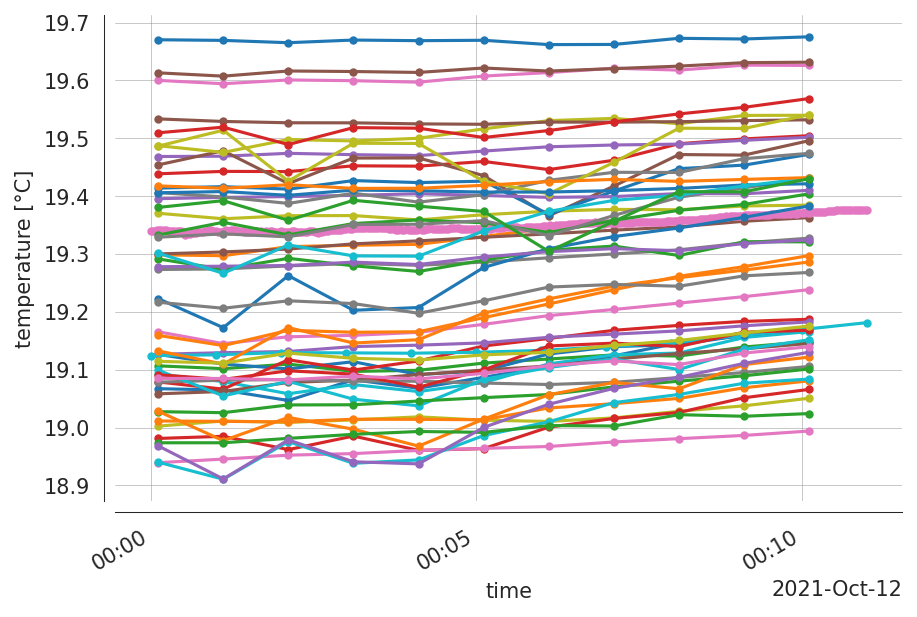

In [133]:
t1 = slice('2021-10-12 00:00:00', '2021-10-12 00:11:00')
fig, ax = gv.plot.quickfig()
[ti.sel(time=t1).plot(ax=ax, marker='.') for ti in tall];

Generate time vector

In [58]:
time_new = np.arange('2021-10-13 16:00:00', '2021-10-13 19:00:00', dtype='datetime64[m]')
time_clock_cal = np.arange('2021-10-14 12:00:00', '2021-10-14 15:00:00', dtype='datetime64[m]')

In [71]:
t2 = slice('2021-10-13 16:00:00', '2021-10-13 19:00:00')

Interpolate

In [59]:
talli = [ti.interp(time=time_new) for ti in tall]
tt = xr.concat(talli, dim='sn', )
tt.coords['sn'] = (('sn'), sn)

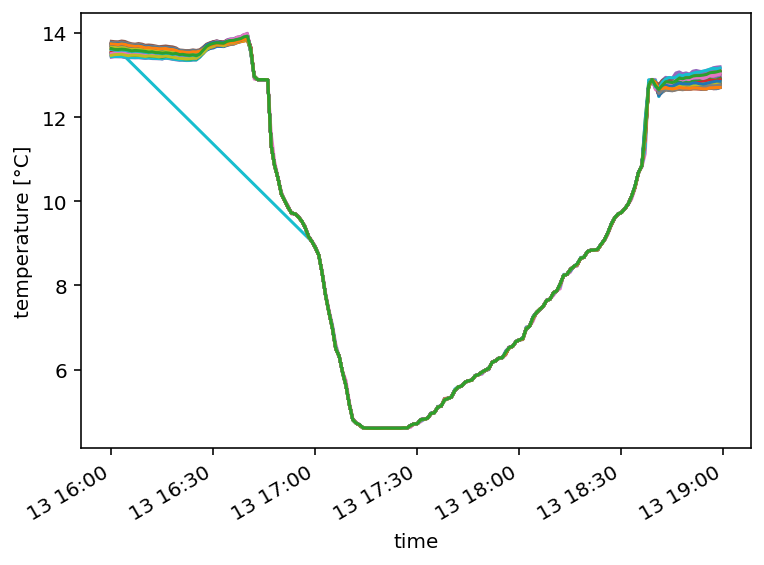

In [67]:
tt.plot(hue='sn', add_legend=False);

SN 5462 shows weird behavior - there is some data missing. For the calibration this is okay as it comes back online before the bottom approach. Looking at Spencer's notes in the log file this thermistor was the only one that showed the 62 events behavior during the calibration cast.

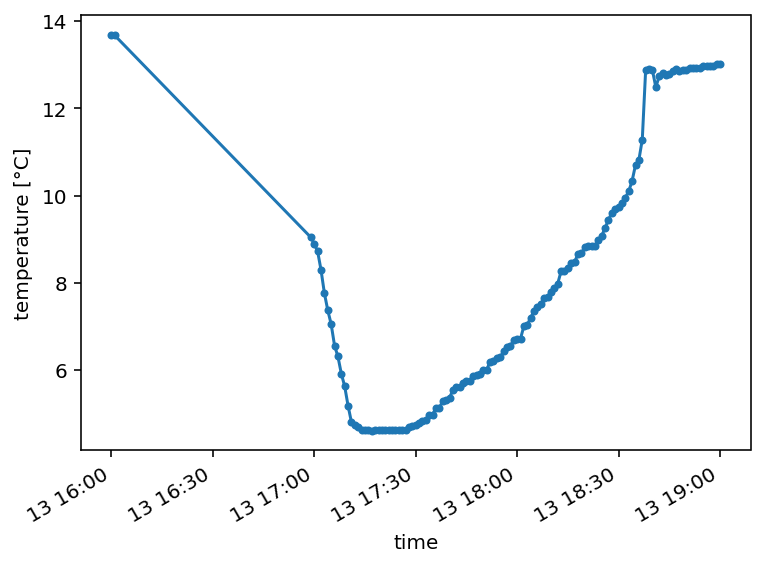

In [83]:
tmp = load_nc(5462)
tmp.sel(time=t2).plot(marker='.');

In [77]:
proc_info.loc[5462]

utc                2021-10-07 10:45:00+00:00
inst               2021-10-07 10:45:04+00:00
cal1               2021-07-07 05:50:30+00:00
cal2               2021-10-06 14:06:00+00:00
Notes                              62 events
processed                               True
raw_data_exists                         True
figure_exists                           True
comment                                   ok
Name: 5462, dtype: object

Let's see if there are any more sensors with gaps. Seems to be just that one sensor...

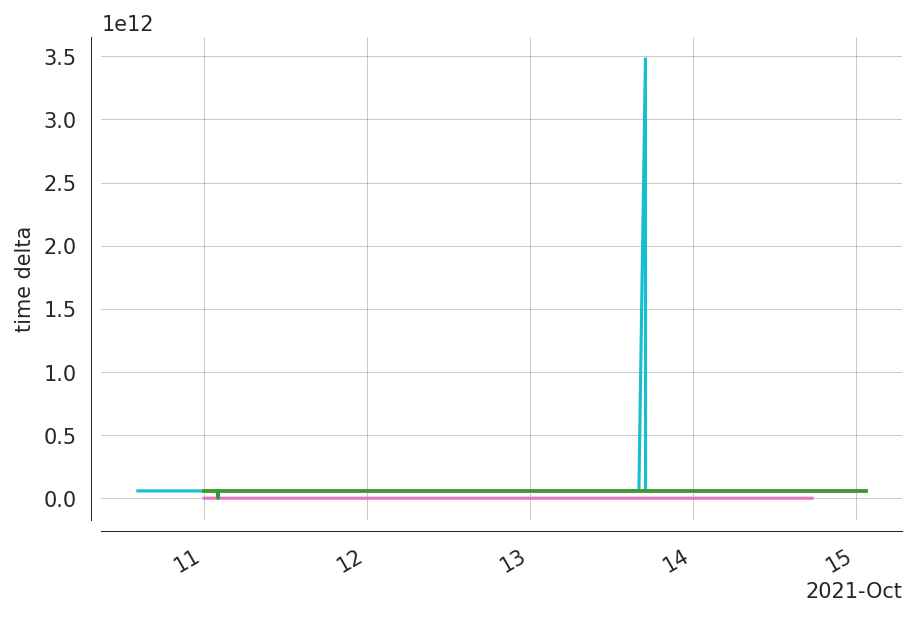

In [132]:
fig, ax = gv.plot.quickfig()
[ti.time.diff(dim='time').plot(ax=ax) for ti in tall]
ax.set(xlabel='', ylabel='time delta')
gv.plot.concise_date(ax)

Okay, this looking pretty good overall. Now we need to find the corresponding CTD cast. We can also plot the clock calibration for all sensors at once.

From the CTD logs it looks like we want CTD cast 62. Let's load the time series.

In [84]:
ctd = xr.open_dataset('/Users/gunnar/Projects/blt/data/blt2/ctd/proc/nc/blt_ctd_24hz_062.nc')

Plot CTD temperature time series and one thermistor.

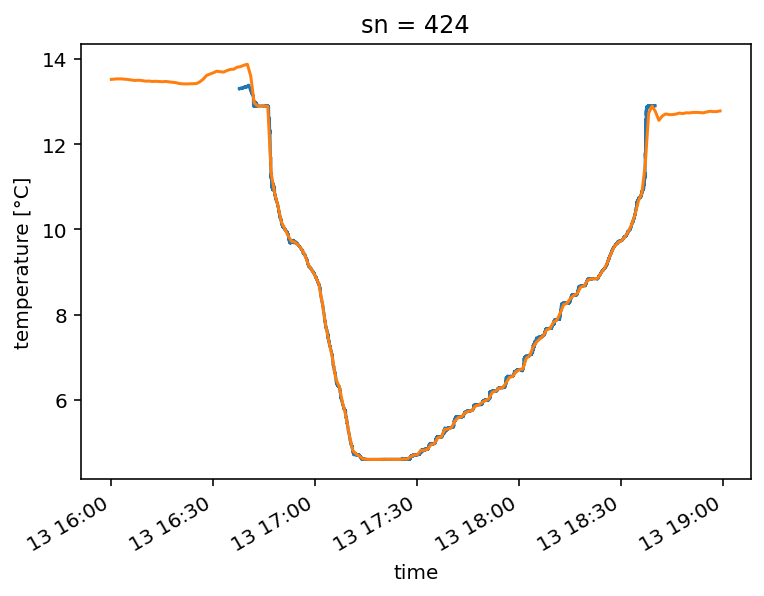

In [86]:
ctd.t1.plot()
tt.isel(sn=10).plot()

In [167]:
t3 = slice('2021-10-13 17:20:00', '2021-10-13 17:22:00')
t4 = slice('2021-10-13 17:15:00', '2021-10-13 17:25:00')

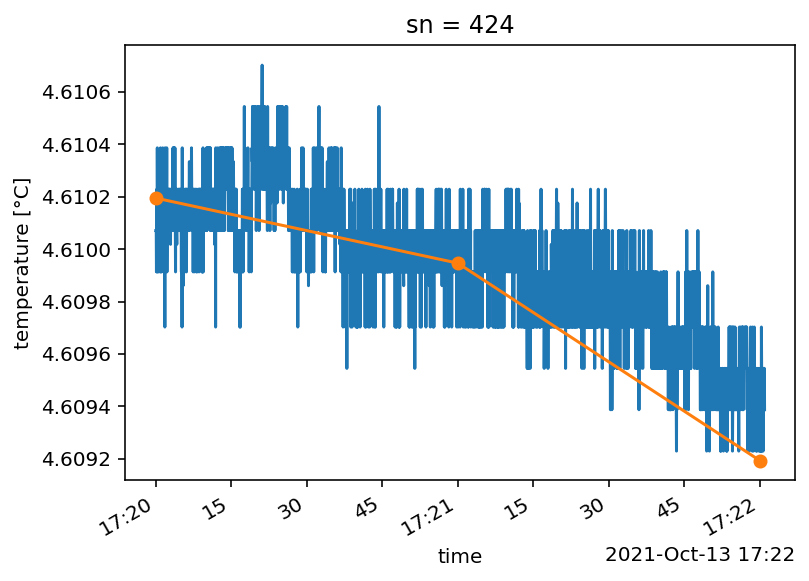

In [168]:
ctd.t1.sel(time=t3).plot()
tt.sel(time=t3).isel(sn=10).plot(marker='o')

All thermistors compared to both CTD sensors. Also show pressure record.

creating figure directory at /Users/gunnar/Projects/blt/proc/sbe56/blt1/fig/


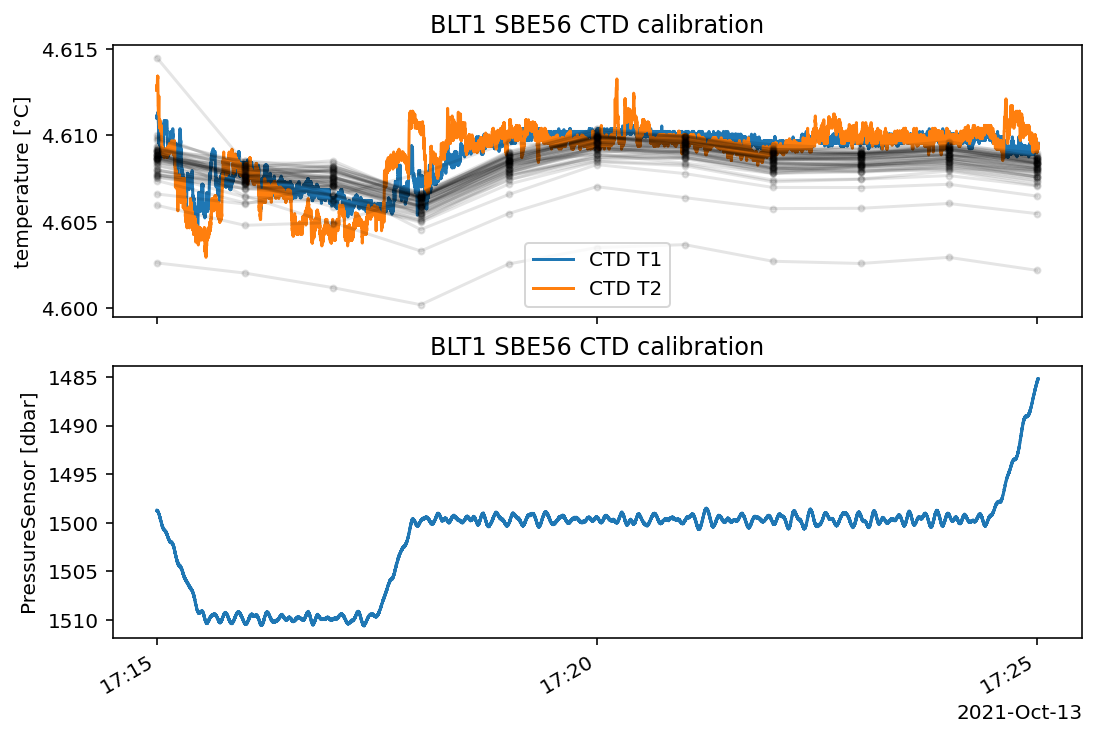

In [229]:
fig, (ax, axp) = plt.subplots(nrows=2, ncols=1, figsize=(7.5, 5),
                       constrained_layout=True, sharex=True)

ctd.p.sel(time=t4).plot(ax=axp)

ctd.t1.sel(time=t4).plot(ax=ax, label='CTD T1')
ctd.t2.sel(time=t4).plot(ax=ax, label='CTD T2')
tt.sel(time=t4).plot(ax=ax, hue='sn', marker='.', add_legend=False, color='k', alpha=0.1);
axp.invert_yaxis()
ax.legend()
for axi in [ax, axp]:
    axi.set(xlabel='', title='BLT1 SBE56 CTD calibration')
gv.plot.concise_date(ax)
gv.plot.png('blt1_sbe56_ctd_cal_bottom')

Most sensors within a couple millidegrees - that's actually not too bad. However, I am slightly concerned about the spread of the offsets around the CTD values. I would have expected something like a normal distribution of offsets centered on the CTD data but instead we see all thermistors showing colder temperatures than the CTD. Why is this? And is this something that we also see in the RBRs?

Just looked at the RBRs and they do not show this behavior. Instead the distribution of their temeperatures is skewed towards warmer than the what the CTD shows.

Let's determine offsets from the few points that we have and save them for each thermistor / serial number. Not sure about how to average best. Maybe pick a window of 20s before the thermistor value from the CTD time series and average over that?

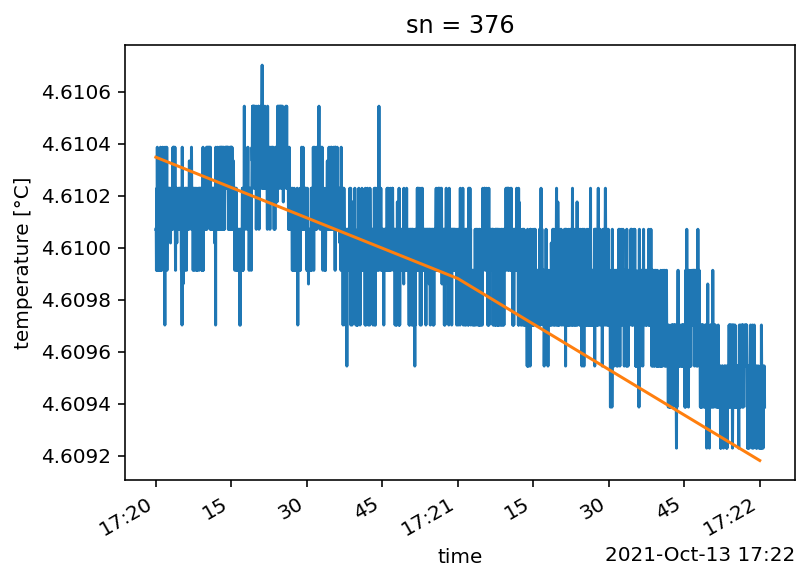

In [170]:
tmp = tt.isel(sn=0).sel(time=t3)
ctd.t1.sel(time=t3).plot()
tmp.plot()

In [172]:
def get_ctd_value(thermistor, dt=20):
    tout = []
    for n, t in thermistor.groupby('time'):
        dts = np.timedelta64(dt, 's')
        tr = slice(n-dts, n)
        ct = ctd.t1.sel(time=tr)
        tout.append(ct.mean().data)
    return np.array(tout)

In [176]:
def get_thermistor_offset(thermistor, dt=20):
    ct = get_ctd_value(thermistor=thermistor, dt=dt)
    offsets = ct - thermistor.data
    return offsets.mean()

In [173]:
test = get_ctd_value(tmp)
print(test)

[4.61004248 4.60999644 4.6095611 ]


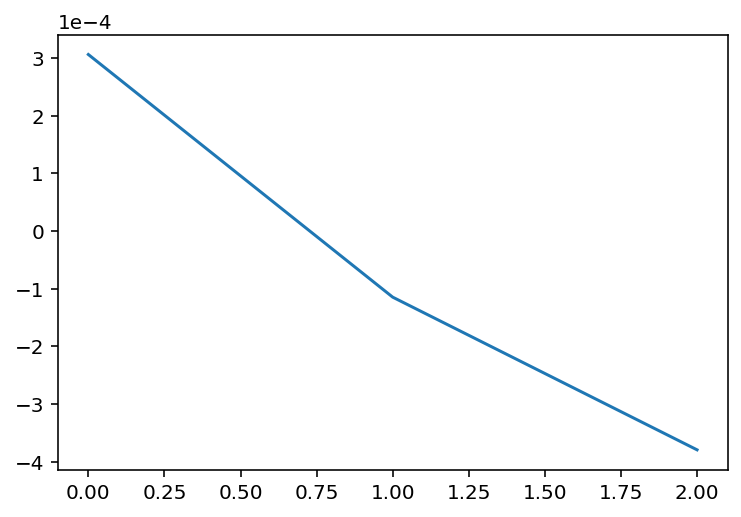

In [174]:
plt.plot(tmp.data-test)

In [177]:
get_thermistor_offset(tmp)

6.278310837704026e-05

In [186]:
mt = []
for n, t in tt.sel(time=t3).groupby('sn'):
    mt.append(get_thermistor_offset(t))
mt = np.array(mt)

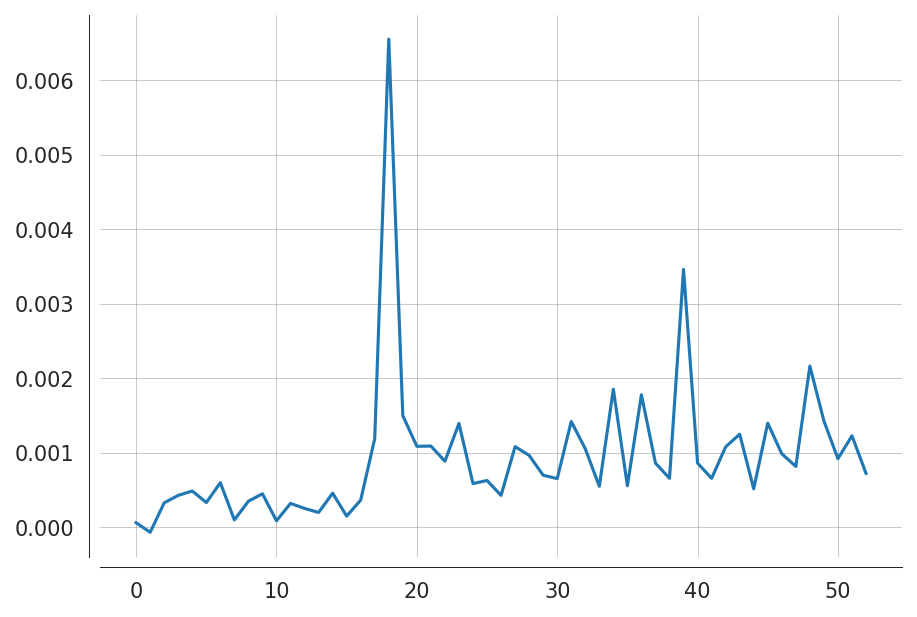

In [187]:
fig, ax = gv.plot.quickfig()
ax.plot(mt)

In [188]:
tt['offset'] = (('sn'), mt)

In [192]:
offset = tt.offset.drop('offset')

In [194]:
offset.to_netcdf('blt1_sbe56_ctd_cal_offsets.nc')